In [1]:

!pip install --disable-pip-version-check -q sagemaker==2.35.0
!pip install --disable-pip-version-check -q nltk==3.5

In [29]:
import boto3
import sagemaker
import pandas as pd
import numpy as np
import botocore
from sagemaker import get_execution_role

sm_boto3 = boto3.client("sagemaker")

sess = sagemaker.Session()

bucket = 'mobucketsagemaker'

region = sess.boto_session.region_name

role = "arn:aws:iam::461481678519:role/service-role/AmazonSageMaker-ExecutionRole-20230803T142487"

print(f"S3 bucket: {bucket}")
print(f"region name: {region}")


S3 bucket: mobucketsagemaker
region name: us-east-1


In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [11]:
!aws s3 cp s3://dlai-practical-data-science/data/balanced/womens_clothing_ecommerce_reviews_balanced.csv ./


Completed 256.0 KiB/2.2 MiB (173.6 KiB/s) with 1 file(s) remaining
Completed 512.0 KiB/2.2 MiB (163.2 KiB/s) with 1 file(s) remaining
Completed 768.0 KiB/2.2 MiB (244.3 KiB/s) with 1 file(s) remaining
Completed 1.0 MiB/2.2 MiB (325.5 KiB/s) with 1 file(s) remaining  
Completed 1.2 MiB/2.2 MiB (406.4 KiB/s) with 1 file(s) remaining  
Completed 1.5 MiB/2.2 MiB (487.4 KiB/s) with 1 file(s) remaining  
Completed 1.8 MiB/2.2 MiB (568.3 KiB/s) with 1 file(s) remaining  
Completed 2.0 MiB/2.2 MiB (649.0 KiB/s) with 1 file(s) remaining  
Completed 2.2 MiB/2.2 MiB (713.5 KiB/s) with 1 file(s) remaining  
download: s3://dlai-practical-data-science/data/balanced/womens_clothing_ecommerce_reviews_balanced.csv to .\womens_clothing_ecommerce_reviews_balanced.csv


In [12]:
path = './womens_clothing_ecommerce_reviews_balanced.csv'

df = pd.read_csv(path, delimiter=',')
df.head()

,sentiment,review_body,product_category
0,-1,This suit did nothing for me. the top has zero...,Swim
1,-1,Like other reviewers i saw this dress on the ...,Dresses
2,-1,I wish i had read the reviews before purchasin...,Knits
3,-1,I ordered these pants in my usual size (xl) an...,Legwear
4,-1,I noticed this top on one of the sales associa...,Knits


In [13]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ACER\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [14]:
sentence = "I'm not a fan of this product!"

tokens = nltk.word_tokenize(sentence)
print(tokens)

['I', "'m", 'not', 'a', 'fan', 'of', 'this', 'product', '!']


In [15]:
def tokenize(review):
    # delete commas and quotation marks, apply tokenization and join back into a string separating by spaces
    return ' '.join([str(token) for token in nltk.word_tokenize(str(review).replace(',', '').replace('"', '').lower())])
    
def prepare_data(df):
    df['sentiment'] = df['sentiment'].map(lambda sentiment : '__label__{}'.format(str(sentiment).replace('__label__', '')))
    ### BEGIN SOLUTION - DO NOT delete this comment for grading purposes
    df['review_body'] = df['review_body'].map(lambda review : tokenize(review)) # Replace all None
    ### END SOLUTION - DO NOT delete this comment for grading purposes
    return df

In [16]:
# create a sample dataframe
df_example = pd.DataFrame({
    'sentiment':[-1, 0, 1], 
    'review_body':[
        "I don't like this product!", 
        "this product is ok", 
        "I do like this product!"]
})

# test the prepare_data function
print(prepare_data(df_example))

# Expected output:
#      sentiment                   review_body
# 0  __label__-1  i do n't like this product !
# 1   __label__0            this product is ok
# 2   __label__1      i do like this product !

     sentiment                   review_body
0  __label__-1  i do n't like this product !
1   __label__0            this product is ok
2   __label__1      i do like this product !


In [17]:
df_blazingtext = df[['sentiment', 'review_body']].reset_index(drop=True)
df_blazingtext = prepare_data(df_blazingtext)
df_blazingtext.head()


,sentiment,review_body
0,__label__-1,this suit did nothing for me . the top has zer...
1,__label__-1,like other reviewers i saw this dress on the c...
2,__label__-1,i wish i had read the reviews before purchasin...
3,__label__-1,i ordered these pants in my usual size ( xl ) ...
4,__label__-1,i noticed this top on one of the sales associa...


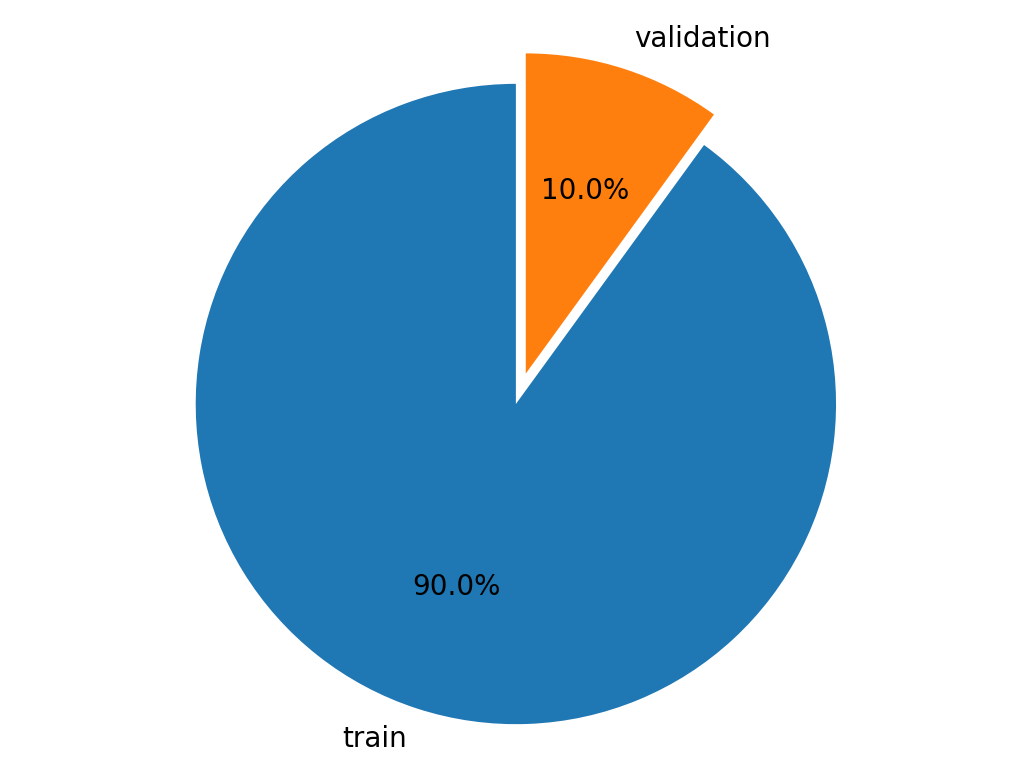

6399


In [18]:
from sklearn.model_selection import train_test_split

# Split all data into 90% train and 10% holdout
df_train, df_validation = train_test_split(df_blazingtext, 
                                           test_size=0.10,
                                           stratify=df_blazingtext['sentiment'])

labels = ['train', 'validation']
sizes = [len(df_train.index), len(df_validation.index)]
explode = (0.1, 0)  

fig1, ax1 = plt.subplots()

ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', startangle=90)

# Equal aspect ratio ensures that pie is drawn as a circle.
ax1.axis('equal')  

plt.show()
print(len(df_train))

In [19]:
blazingtext_train_path = './train.csv'
df_train[['sentiment', 'review_body']].to_csv(blazingtext_train_path, index=False, header=False, sep=' ')

In [20]:
blazingtext_validation_path = './validation.csv'
df_validation[['sentiment', 'review_body']].to_csv(blazingtext_validation_path, index=False, header=False, sep=' ')

In [21]:
train_s3_uri = sess.upload_data(bucket=bucket, key_prefix='blazingtext/data', path=blazingtext_train_path)
validation_s3_uri = sess.upload_data(bucket=bucket, key_prefix='blazingtext/data', path=blazingtext_validation_path)

In [22]:
image_uri = sagemaker.image_uris.retrieve(
    region=region,
    ### BEGIN SOLUTION - DO NOT delete this comment for grading purposes
    framework='blazingtext' # Replace None
    ### END SOLUTION - DO NOT delete this comment for grading purposes
)

In [30]:
estimator = sagemaker.estimator.Estimator(
    ### BEGIN SOLUTION - DO NOT delete this comment for grading purposes
    image_uri=image_uri, # Replace None
    ### END SOLUTION - DO NOT delete this comment for grading purposes
    role=role, 
    instance_count=1, 
    instance_type='ml.m5.large',
    volume_size=30,
    max_run=7200,
    sagemaker_session=sess
)

In [31]:
estimator.set_hyperparameters(mode='supervised',   # supervised (text classification)
                              epochs=10,           # number of complete passes through the dataset: 5 - 15
                              learning_rate=0.01,  # step size for the  numerical optimizer: 0.005 - 0.01
                              min_count=2,         # discard words that appear less than this number: 0 - 100                              
                              vector_dim=300,      # number of dimensions in vector space: 32-300
                              word_ngrams=3)       # number of words in a word n-gram: 1 - 3

In [32]:
train_data = sagemaker.inputs.TrainingInput(
    ### BEGIN SOLUTION - DO NOT delete this comment for grading purposes
    train_s3_uri, # Replace None
    ### END SOLUTION - DO NOT delete this comment for grading purposes
    distribution='FullyReplicated', 
    content_type='text/plain', 
    s3_data_type='S3Prefix'
)

In [33]:
validation_data = sagemaker.inputs.TrainingInput(
    ### BEGIN SOLUTION - DO NOT delete this comment for grading purposes
    validation_s3_uri, # Replace None
    ### END SOLUTION - DO NOT delete this comment for grading purposes
    distribution='FullyReplicated', 
    content_type='text/plain', 
    s3_data_type='S3Prefix'
)

In [34]:
data_channels = {
    ### BEGIN SOLUTION - DO NOT delete this comment for grading purposes
    'train': train_data, # Replace None
    'validation': validation_data # Replace None
    ### END SOLUTION - DO NOT delete this comment for grading purposes
}

In [35]:
estimator.fit(
    ### BEGIN SOLUTION - DO NOT delete this comment for grading purposes
    inputs=data_channels, # Replace None
    ### END SOLUTION - DO NOT delete this comment for grading purposes
    wait=False
)

training_job_name = estimator.latest_training_job.name
print('Training Job Name:  {}'.format(training_job_name))

Training Job Name:  blazingtext-2023-08-03-09-23-28-739


In [36]:
from IPython.core.display import display, HTML

display(HTML('<b>Review <a target="blank" href="https://console.aws.amazon.com/sagemaker/home?region={}#/jobs/{}">Training job</a></b>'.format(region, training_job_name)))

C:\Users\ACER\AppData\Local\Temp\ipykernel_7912\3585361345.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [37]:
from IPython.core.display import display, HTML

display(HTML('<b>Review <a target="blank" href="https://console.aws.amazon.com/cloudwatch/home?region={}#logStream:group=/aws/sagemaker/TrainingJobs;prefix={};streamFilter=typeLogStreamPrefix">CloudWatch logs</a> (after about 5 minutes)</b>'.format(region, training_job_name)))

C:\Users\ACER\AppData\Local\Temp\ipykernel_7912\1685692383.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [38]:
%%time

estimator.latest_training_job.wait(logs=False)


2023-08-03 09:24:12 Starting - Preparing the instances for training.
2023-08-03 09:24:37 Downloading - Downloading input data...........
2023-08-03 09:25:44 Training - Training image download completed. Training in progress.......
2023-08-03 09:26:19 Uploading - Uploading generated training model......................................
2023-08-03 09:29:45 Completed - Training job completed
CPU times: total: 297 ms
Wall time: 5min 16s


In [39]:
estimator.training_job_analytics.dataframe()

,timestamp,metric_name,value
0,0.0,train:accuracy,0.5373
1,0.0,validation:accuracy,0.5345


In [41]:
from IPython.core.display import display, HTML
display(HTML('<b>Review <a target="blank" href="https://s3.console.aws.amazon.com/s3/buckets/{}/{}/output/?region={}&tab=overview">Trained model</a> in S3</b>'.format(bucket, training_job_name, region)))


C:\Users\ACER\AppData\Local\Temp\ipykernel_7912\3434203295.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [42]:
%%time

text_classifier = estimator.deploy(initial_instance_count=1,
                                   instance_type='ml.m5.large',
                                   serializer=sagemaker.serializers.JSONSerializer(),
                                   deserializer=sagemaker.deserializers.JSONDeserializer())

print()
print('Endpoint name:  {}'.format(text_classifier.endpoint_name))

-----!
Endpoint name:  blazingtext-2023-08-03-09-30-40-657
CPU times: total: 15.6 ms
Wall time: 2min 34s


In [43]:
from IPython.core.display import display, HTML

display(HTML('<b>Review <a target="blank" href="https://console.aws.amazon.com/sagemaker/home?region={}#/endpoints/{}">SageMaker REST Endpoint</a></b>'.format(region, text_classifier.endpoint_name)))


C:\Users\ACER\AppData\Local\Temp\ipykernel_7912\3114295367.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [44]:
reviews = ['This product is great!',
           'OK, but not great',
           'This is not the right product.'] 

In [49]:
tokenized_reviews = [' '.join(nltk.word_tokenize(review)) for review in reviews]
# print(tokenized_reviews)
payload = {"instances" : tokenized_reviews}
print(payload)

{'instances': ['This product is great !', 'OK , but not great', 'This is not the right product .']}


In [46]:
predictions = text_classifier.predict(data=payload)
for prediction in predictions:
    print('Predicted class: {}'.format(prediction['label'][0].lstrip('__label__')))

Predicted class: 1
Predicted class: 0
Predicted class: -1
